In [92]:
# The following project will test 5 pre-trained models for accuracy on Alzheimer image dataset and
# will the app will be available online. 

In [93]:
#                                                                           OUTLINE 

# Phase 1 : Project Planning and Project Setup
# Phase 2 : Data Collection and Data Labeling
# Phase 3 : Model Training and Model Debugging
# Phase 4 : Model Deployment and Model Testing

In [94]:
                                                            # 1. Project Planning and Project Setup
                                            
# The initial thought was to create a simple CNN model for image classification. However there are extremely well-formulated and pre-trained models on the market that 
# will be tested regarding accuracy and quality on a specific (first) set of images acquired from Kaggle (> 5k files). 
# Then a second set of images will be applied to the model (> 40k files).

# The whole process will run on Cuda GPU for fast processing.                                             

In [1]:
# BRING IN THE LIBRARIES

import numpy as np
import pandas as pd

import os

# visualization librairies
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import torch
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torchvision.models as models
import torch.nn as nn

from torch.utils.data import DataLoader, Dataset

# set up GPU 
torch.cuda.empty_cache()
test_gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if test_gpu else "cpu")

print("Cuda is available : ", test_gpu)
print("Device chosen : ", device)

# user interface
import tkinter as tk
from tkinter import simpledialog    
ROOT = tk.Tk()
ROOT.withdraw()

# Set the parameters that control the scaling of plot elements.
sns.set_context('notebook')
sns.set_style('white')

Cuda is available :  True
Device chosen :  cuda:0


In [2]:

                                                                  # 2  Data Collection and Data Labeling
                                                                  
class Data(Dataset):
     def __init__(self) -> None:          
          super(Data, self).__init__()
          
          # data directories  
          self.train_dir = './Alzheimer_Data_mini/Alzheimer_s Dataset/train'                                      
          self.test_dir = './Alzheimer_Data_mini/Alzheimer_s Dataset/test'
          
          # transform section
          mean =  [0.485, 0.456, 0.406] 
          std = [0.229, 0.224, 0.225]
          
          self.composed = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), transforms.ToTensor(), transforms.Normalize(mean, std)])
          self.composed_inception= transforms.Compose([transforms.Resize(342), transforms.CenterCrop(299), transforms.ToTensor(), transforms.Normalize(mean, std)]) # line for inception model
          
     def train(self): 
                                                                                
          self.train_data = dsets.ImageFolder(root=self.train_dir, transform=self.composed)                              
          self.len_train_data = len(self.train_data) # training dataset size                             
          return self.train_data
     
     def train_inception(self):
          
          self.train_data_inception = dsets.ImageFolder(root=self.train_dir, transform=self.composed_inception)
          self.len_train_data_inception = len(self.train_data_inception)
          return self.train_data_inception          
          
     def val(self):  
                       
          self.val_data = dsets.ImageFolder(root=self.test_dir, transform=self.composed)                              
          self.len_val_data = len(self.val_data)  # validation dataset size                                      
          return self.val_data
     
     def val_inception(self):  
                       
          self.val_data_inception = dsets.ImageFolder(root=self.test_dir, transform=self.composed_inception)                                                                              
          self.len_val_data_inception = len(self.val_data_inception)
          return self.val_data_inception
     
     def n_classes(self) -> None:     
                
          self.n_train_classes = [f for f in os.listdir(self.train_dir) if not f.startswith('.')]          
          self.n_test_classes = [f for f in os.listdir(self.test_dir) if not f.startswith('.')]          
          
          print("Train classes : ", self.n_train_classes, "\n", "Test classes : ", self.n_test_classes)
          self.len_classes = len(self.n_train_classes)          
                    
          
     def __len__(self) -> int:               
          return self.len_train_data, self.len_val_data, self.len_train_data_inception, self.len_val_data_inception, self.len_classes     

In [3]:
# Create a Data object

data = Data()

train_data = data.train()
val_data = data.val()

train_data_inception = data.train_inception()
val_data_inception = data.val_inception()

print(f"The dataset consists of {len(train_data)} train data and {len(val_data)} validation (test) data\n")

data.n_classes()

The dataset consists of 5121 train data and 1279 validation (test) data

Train classes :  ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'] 
 Test classes :  ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


In [106]:
# By default, when we load a pretrained model all of the parameters have .requires_grad=True, which is fine if we are training from scratch or finetuning. 
# However, if we are feature extracting and only want to compute gradients for the newly initialized layer then we want all of the other parameters to not require gradients.

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [109]:
# Initialize the variables for the model

num_classes = 4 # classes of the dataset       
feature_extract = False # when True we only update the reshaped layer params, when False, we finetune the whole model

In [110]:
#                                                                  3. Model Training and Model Debugging

# Load the best 5 pretrained torch models for image classification (DenseNet 201, ResNet50, VGG16, VGG19_BN, Inception_V3)
    
def initialize_model(model_name, num_classes, feature_extract):
                                     
    model_ft = None        
    
    if model_name == "densenet":
        
        weights_201 = models.DenseNet201_Weights.DEFAULT
        model_201 = models.densenet201(weights=weights_201)
        model_ft = model_201
        set_parameter_requires_grad(model_ft, feature_extract)   
        model_ft.classifier = nn.Linear(model_ft.classifier.in_features, num_classes) # fc input features, classes        
                                    
    elif model_name == "resnet":
        
        weights_50 = models.ResNet50_Weights.DEFAULT
        model_50 = models.resnet50(weights=weights_50) 
        model_ft = model_50
        set_parameter_requires_grad(model_ft, feature_extract)                
        model_ft.fc = nn.Linear(model_ft.fc.in_features, num_classes)        

    elif model_name == "vgg16":
        
        weights_16 = models.VGG16_Weights.DEFAULT
        model_16 = models.vgg16(weights=weights_16) 
        model_ft = model_16
        set_parameter_requires_grad(model_ft, feature_extract)                         
        model_ft.classifier[6] = nn.Linear(model_ft.classifier[6].in_features, num_classes)        
    
    elif model_name == "vgg19":
        
        weights_19_bn = models.VGG19_BN_Weights.DEFAULT
        model_19_bn = models.vgg19_bn(weights=weights_19_bn) 
        model_ft = model_19_bn
        set_parameter_requires_grad(model_ft, feature_extract)                                 
        model_ft.classifier[6] = nn.Linear(model_ft.classifier[6].in_features, num_classes)        
    
    elif model_name == "inception":
        
        weights_inception = models.Inception_V3_Weights.DEFAULT
        model_inception = models.inception_v3(weights=weights_inception)
        model_ft = model_inception
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.AuxLogits.fc = nn.Linear(model_ft.AuxLogits.fc.in_features, num_classes)            
        model_ft.fc = nn.Linear(model_ft.fc.in_features, num_classes)                                         
    
    else:
        print("Invalid model name, exiting...")
        
        exit()
        
    return model_ft

In [111]:
# CALL THE MODEL 

model_name = simpledialog.askstring(title = " Pick model ", prompt = " resnet or vgg16 or vgg19 or densenet or inception ")
model_name = model_name.lower()

model_ft = initialize_model(model_name, num_classes, feature_extract)       
model_ft.to(device)    

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [112]:
# Gather the parameters to be optimized/updated in this run. If we are finetuning we will be updating all parameters.
# However, if we are doing feature extract method, we will only update the parameters that we have just initialized, i.e. the parameters with requires_grad is True.

def parameters_to_update():    

    params_to_update = model_ft.parameters()
    print("Params to learn:")

    if feature_extract:
        params_to_update = []
        for name,param in model_ft.named_parameters():
            if param.requires_grad == True:
                params_to_update.append(param)
                print("\t",name)
    else:
        for name,param in model_ft.named_parameters():
            if param.requires_grad == True:
                print("\t",name)            
    
    return params_to_update 

In [113]:
# Create object for parameters update function

params_to_update = parameters_to_update()           

Params to learn:
	 Conv2d_1a_3x3.conv.weight
	 Conv2d_1a_3x3.bn.weight
	 Conv2d_1a_3x3.bn.bias
	 Conv2d_2a_3x3.conv.weight
	 Conv2d_2a_3x3.bn.weight
	 Conv2d_2a_3x3.bn.bias
	 Conv2d_2b_3x3.conv.weight
	 Conv2d_2b_3x3.bn.weight
	 Conv2d_2b_3x3.bn.bias
	 Conv2d_3b_1x1.conv.weight
	 Conv2d_3b_1x1.bn.weight
	 Conv2d_3b_1x1.bn.bias
	 Conv2d_4a_3x3.conv.weight
	 Conv2d_4a_3x3.bn.weight
	 Conv2d_4a_3x3.bn.bias
	 Mixed_5b.branch1x1.conv.weight
	 Mixed_5b.branch1x1.bn.weight
	 Mixed_5b.branch1x1.bn.bias
	 Mixed_5b.branch5x5_1.conv.weight
	 Mixed_5b.branch5x5_1.bn.weight
	 Mixed_5b.branch5x5_1.bn.bias
	 Mixed_5b.branch5x5_2.conv.weight
	 Mixed_5b.branch5x5_2.bn.weight
	 Mixed_5b.branch5x5_2.bn.bias
	 Mixed_5b.branch3x3dbl_1.conv.weight
	 Mixed_5b.branch3x3dbl_1.bn.weight
	 Mixed_5b.branch3x3dbl_1.bn.bias
	 Mixed_5b.branch3x3dbl_2.conv.weight
	 Mixed_5b.branch3x3dbl_2.bn.weight
	 Mixed_5b.branch3x3dbl_2.bn.bias
	 Mixed_5b.branch3x3dbl_3.conv.weight
	 Mixed_5b.branch3x3dbl_3.bn.weight
	 Mixed_5b.b

In [114]:
# Criterion, Optimizer, DataLoader

criterion = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer_ft = torch.optim.Adam(params_to_update, lr=learning_rate) 

train_loader = DataLoader(dataset=train_data, batch_size=8, drop_last=True)
val_loader = DataLoader(dataset=val_data, batch_size=8, drop_last=True)

train_loader_inception = DataLoader(dataset=train_data_inception, batch_size=8, drop_last=True)
val_loader_inception = DataLoader(dataset=val_data_inception, batch_size=8, drop_last=True)

In [115]:
N_EPOCHS = 15 # number of epochs for training (CAN ALWAYS BE ALTERED)

min_loss = 1.00 # ---> how much minimum loss do you wish to have (CAN ALWAYS BE ALTERED)
min_acc = 0.80 # ---> how much minimum accuracy do you wish to have (CAN ALWAYS BE ALTERED)

In [116]:
def train_model(model, train_loader, validation_loader, optimizer, n_epochs, min_loss, min_acc): 
    
    correct = 0 # for accuracy

    n_test = len(val_data) 
    
    useful_stuff = {'training_loss':[], 'validation_accuracy':[]}   
                
    for epoch in range(n_epochs):
        
        loss_sublist = []                
        
        for i, (features, labels) in enumerate(train_loader):            
            
            features, labels = features.to(device), labels.to(device)
                                    
            model.train()
            
            optimizer.zero_grad()
                        
            # loss section start            
            # Special case for inception because in training it has an auxiliary output. 
            # In train mode we calculate the loss by summing the final output and the auxiliary output
            # but in testing we only consider the final output.                        
            if model_name == "inception":                
                predictions, aux_outputs = model(features)                
                loss1 = criterion(predictions, labels)
                loss2 = criterion(aux_outputs, labels)
                loss = loss1 + 0.4*loss2                
            else:                
                predictions = model(features)                        
                loss = criterion(predictions, labels)    
                                
            loss_sublist.append(loss.data.item())
            
            loss.backward() 
            # loss section end
            
            optimizer.step()
            
        useful_stuff['training_loss'].append(np.mean(loss_sublist))
                                
        for stuff_loss in useful_stuff['training_loss']:
            if stuff_loss < min_loss:
                value = epoch
                min_loss = stuff_loss
                torch.save(model.state_dict(), './train_best.pt')

        correct=0
        #perform a prediction on the validation  data  
        for features, labels in validation_loader:
            
            features, labels = features.to(device), labels.to(device)
                        
            model.eval()
            
            predictions = model(features)
            
            _, yhat = torch.max(predictions.data, 1)
            correct += (yhat == labels).sum().item()
            
        accuracy = correct / n_test
        useful_stuff['validation_accuracy'].append(accuracy)
        
        for stuff_acc in useful_stuff['validation_accuracy']:
            if stuff_acc > min_acc:
                value = epoch
                min_acc = stuff_acc
                torch.save(model.state_dict(), './validation_best.pt')        
     
    return useful_stuff

In [66]:
                                                                                # !!!!

                                                                           # RESHAPED LAYER

                                                                                # !!!!

# weights = DEFAULT
# feature_extract = True     

In [38]:
train_inception=train_model(model_ft, train_loader_inception, val_loader_inception, optimizer_ft, N_EPOCHS, min_loss, min_acc)

In [52]:
train_19_bn=train_model(model_ft, train_loader, val_loader, optimizer_ft, N_EPOCHS, min_loss, min_acc)

In [75]:
train_50=train_model(model_ft, train_loader, val_loader, optimizer_ft, N_EPOCHS, min_loss, min_acc)

In [84]:
train_16=train_model(model_ft, train_loader, val_loader, optimizer_ft, N_EPOCHS, min_loss, min_acc)

In [101]:
train_201=train_model(model_ft, train_loader, val_loader, optimizer_ft, N_EPOCHS, min_loss, min_acc)

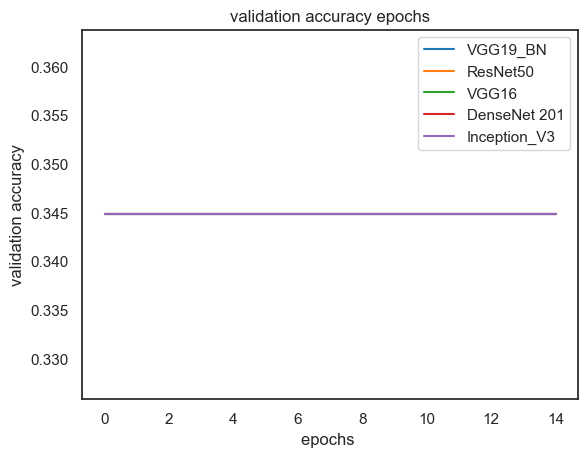

In [104]:
# Plot the accuracy : AFTER N_EPOCHS

plt.plot(train_19_bn['validation_accuracy'], label='VGG19_BN')
plt.plot(train_50['validation_accuracy'], label='ResNet50')
plt.plot(train_16['validation_accuracy'], label='VGG16')
plt.plot(train_201['validation_accuracy'], label='DenseNet 201')
plt.plot(train_inception['validation_accuracy'], label='Inception_V3')
plt.ylabel('validation accuracy')
plt.xlabel('epochs ')
plt.title('validation accuracy epochs')
plt.legend()
plt.show()

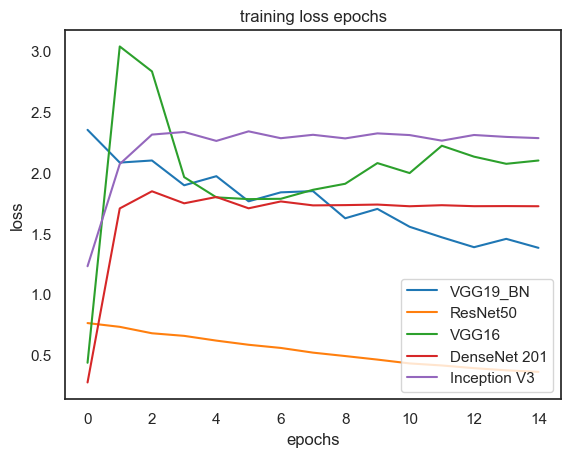

In [105]:
# Plot the loss : AFTER N_EPOCHS

plt.plot(train_19_bn['training_loss'], label='VGG19_BN')
plt.plot(train_50['training_loss'], label='ResNet50')
plt.plot(train_16['training_loss'], label='VGG16')
plt.plot(train_201['training_loss'], label='DenseNet 201')
plt.plot(train_inception['training_loss'], label='Inception V3')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.title('training loss epochs')
plt.legend()
plt.show()

In [ ]:
# MOST PROMISING AFTER TRAINING WITH RESHAPED LAYER AND DEFAULT WEIGHTS :  ResNet50, VGG19_BN

In [ ]:
                                                                                # !!!!

                                                                           # FULL MODEL TUNED

                                                                                # !!!!


# weights = DEFAULT
# feature_extract = False    

In [117]:
train_inception=train_model(model_ft, train_loader_inception, val_loader_inception, optimizer_ft, N_EPOCHS, min_loss, min_acc)

In [ ]:
train_19_bn=train_model(model_ft, train_loader, val_loader, optimizer_ft, N_EPOCHS, min_loss, min_acc)

In [ ]:
train_50=train_model(model_ft, train_loader, val_loader, optimizer_ft, N_EPOCHS, min_loss, min_acc)

In [ ]:
train_16=train_model(model_ft, train_loader, val_loader, optimizer_ft, N_EPOCHS, min_loss, min_acc)

In [ ]:
train_201=train_model(model_ft, train_loader, val_loader, optimizer_ft, N_EPOCHS, min_loss, min_acc)

In [ ]:
# MOST PROMISING AFTER TRAINING THE WHOLE MODEL WITH DEFAULT WEIGHTS :

In [ ]:
# Plot the accuracy : AFTER N_EPOCHS

plt.plot(train_19_bn['validation_accuracy'], label='VGG19_BN')
plt.plot(train_50['validation_accuracy'], label='ResNet50')
plt.plot(train_16['validation_accuracy'], label='VGG16')
plt.plot(train_201['validation_accuracy'], label='DenseNet 201')
plt.plot(train_inception['validation_accuracy'], label='Inception_V3')
plt.ylabel('validation accuracy')
plt.xlabel('epochs ')
plt.title('validation accuracy epochs')
plt.legend()
plt.show()

In [ ]:
# Plot the loss : AFTER N_EPOCHS

plt.plot(train_19_bn['training_loss'], label='VGG19_BN')
plt.plot(train_50['training_loss'], label='ResNet50')
plt.plot(train_16['training_loss'], label='VGG16')
plt.plot(train_201['training_loss'], label='DenseNet 201')
plt.plot(train_inception['training_loss'], label='Inception V3')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.title('training loss epochs')
plt.legend()
plt.show()

In [ ]:
                                                                                # !!!!

                                                                    # FULL MODEL TUNED with no weights

                                                                                # !!!!


# weights = None
# feature_extract = False    

In [ ]:
# Plot the accuracy OF THE LOADED (DEFAULT WEIGHT) MODELS : AFTER N_EPOCHS

# plt.plot(train_19_bn['validation_accuracy'], label='VGG19_BN')
# plt.plot(train_50['validation_accuracy'], label='ResNet50')
# plt.plot(train_16['validation_accuracy'], label='VGG16')
# plt.plot(train_201['validation_accuracy'], label='DenseNet 201')
# plt.plot(train_inception['validation_accuracy'], label='Inception_V3')
# plt.ylabel('validation accuracy')
# plt.xlabel('epochs ')
# plt.title('validation accuracy epochs')
# plt.legend()
# plt.show()

In [ ]:
# Plot the loss OF THE LOADED (DEFAULT WEIGHT) MODELS : AFTER N_EPOCHS

# plt.plot(train_19_bn['training_loss'], label='VGG19_BN')
# plt.plot(train_50['training_loss'], label='ResNet50')
# plt.plot(train_16['training_loss'], label='VGG16')
# plt.plot(train_201['training_loss'], label='DenseNet 201')
# plt.plot(train_inception['training_loss'], label='Inception V3')
# plt.ylabel('loss')
# plt.xlabel('epochs')
# plt.title('training loss epochs')
# plt.legend()
# plt.show()

In [ ]:
#                                                                           4. Model Deployment and Model Testing